In [1]:
# Torch
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import torch.optim as optim
from torcheval.metrics import *

# Benny pointnet
from pointnet2_benny import pointnet2_cls_msg
from pointnet2_benny import provider

# Other
from tqdm import tqdm
import nibabel
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_score, recall_score, accuracy_score, roc_auc_score
from collections import Counter
import random
import datetime

# Custom modules
from preprocessing_post_fastsurfer.subject import *
from preprocessing_post_fastsurfer.vis import *
from ozzy_torch_utils.split_dataset import *
from ozzy_torch_utils.SubjectDataset import *

### Dataset hyperparameters

In [4]:
data_path = "/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/scratch-disk/full-datasets/adni1-complete-3T-processed"

selected_labels = ['CN', 'MCI']

# Dictionary key representing the data of interest
data_string = 'hcampus_pointcloud'

# Dictionary key representing the disease labels
labels_string = 'research_group'

downsample_majority=False

batch_size = 20

test_size = 0.2

### Dataset creation

In [5]:
dataset = SubjectDataset(data_path, selected_labels, downsample_majority=downsample_majority)

### Data checks

In [6]:
print(f"Dataset size: {len(dataset)}\n")

labels = []

for subject in range(len(dataset.subject_list)):
    
    group = dataset.__getitem__(subject)['research_group']
    
    labels.append(group)
    
print(f"Unique labels: {np.unique(labels)}\n")

print("Labels count: ")
print(Counter(labels))


Dataset size: 386

Unique labels: [0 1]

Labels count: 
Counter({1: 226, 0: 160})


### Loader config

In [7]:

train_data, test_data = split_dataset(dataset, test_size=test_size)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn([data_string, labels_string]))

test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn([data_string, labels_string]))



### Cuda setup

In [8]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"

print(f"Using {device} device")

Using cuda device


Notes
- Strange issue where first run (from restart) of the model gives convincing results
- After this, all epochs (even on restart) predict entirely one class and this class swaps over
- Downsampling majority class hasn't fixed this
- Could this be to do with argmax. How should I convert outputs into classes
- Could it be overfitting? Do i need more data

- After 7 epochs, got 65% accuracy with non downsampled majority, learning rate of 0.0001

### Training hyperparameters

In [9]:
num_epochs = 1

learning_rate = 0.001

threshold = 0.5

In [10]:
from torcheval.metrics import *

num_classes = dataset.num_classes

training_losses, validation_losses, conf_matrices, accuracies, f1s, precisions, recalls = [], [], [], [], [], [], []

model = pointnet2_cls_msg.get_model(num_classes, normal_channel=False)

criterion = pointnet2_cls_msg.get_loss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

model.to(device)

start_time = datetime.datetime.now()

for epoch in range(num_epochs):
    
    print(f"Starting epoch {epoch + 1}\n")
    
    # Training loop
    model.train()
    
    running_loss = 0.0

    for batch_idx, dict in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        
        # Access dict returned by dataset __getitem__
        points = dict[data_string]
        labels = dict[labels_string]
        
        # Transpose as in benny script (NB why does it need a transpose)
        points = points.transpose(2, 1)
        
        points, labels = points.to(device), labels.to(device)

        # Forward pass
        output, _ = model(points)

        # Calculate loss, trans_feat argument as None as not used in this function
        loss = criterion(output, labels, None)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        # Multiply loss by batch size to account for differences in batch size (e.g last batch)
        running_loss += loss.item() * points.size(0)
        
    training_losses.append(running_loss/len(train_dataloader))
    
    end_time = datetime.datetime.now()
    
    # Validation loop
    model.eval()
    
    running_loss = 0.0
        
    conf_matrix = BinaryConfusionMatrix()
    
    accuracy = BinaryAccuracy()
    
    f1 = BinaryF1Score()

    precision = BinaryPrecision()
    
    recall = BinaryRecall()
    
    with torch.no_grad():
        
        for batch_idx, dict in enumerate(test_dataloader):
            
            points = dict[data_string]
            labels = dict[labels_string]
            
            points = points.transpose(2, 1)
            
            points, labels = points.to(device), labels.to(device)
            
            output, _ = model(points)
            
            running_loss += criterion(output, labels, None).item() * points.size(0)
            
            # Apply exponent as the output of the model is log softmax
            pred_probability = torch.exp(output)
            
            # Threshold is variable to give preference to FN or FP
            pred_labels = (pred_probability[:, 1] >= threshold).int()
            
            # Old label conversion
            # pred_labels = torch.argmax(pred_probability, dim=-1)

            # Update metrics
            [metric.update(pred_labels, labels) for metric in [conf_matrix, accuracy, f1, precision, recall]]

    end_time = datetime.datetime.now()
            
    # Append metric lists
    [metric_list.append(metric.compute()) for metric_list, metric in [(conf_matrices, conf_matrix), (accuracies, accuracy), (f1s, f1), (precisions, precision), (recalls, recall)]]
            
    validation_losses.append(running_loss/len(test_dataloader))
                    
    #ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=selected_labels).plot()
    
    print(conf_matrix.compute())
    
    print(f"\n Epoch {epoch + 1} complete\n")
    print(f"Training loss: {training_losses[-1]}\n")
    print(f"Validation loss: {validation_losses[-1]}\n")
    print(f"Accuracy: {accuracies[-1]}\n")
    print(f"F1: {f1s[-1]}\n")
    print(f"Precision: {precisions[-1]}\n")
    print(f"Recall: {recalls[-1]}\n")
    print("------------------------\n\n\n")

torch.save(model.state_dict(), 'trained_model.pth')
print("Training complete and model saved")

Starting epoch 1



100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


tensor([[31.,  0.],
        [46.,  0.]])

 Epoch 1 complete

Training loss: 14.515150491148233

Validation loss: 21.453978717327118

Accuracy: 0.4025973975658417

F1: 0.0

Precision: 0.0

Recall: 0.0

------------------------



Training complete and model saved


In [11]:
# Compute best epoch and the stats of this epoch
best_epoch = validation_losses.index(min(validation_losses))

train_time = end_time - start_time

minutes = train_time.seconds // 60

seconds = train_time.seconds % 60

train_time_str = f"Training time: {minutes:02d}m {seconds:02d}s"

### Plotting

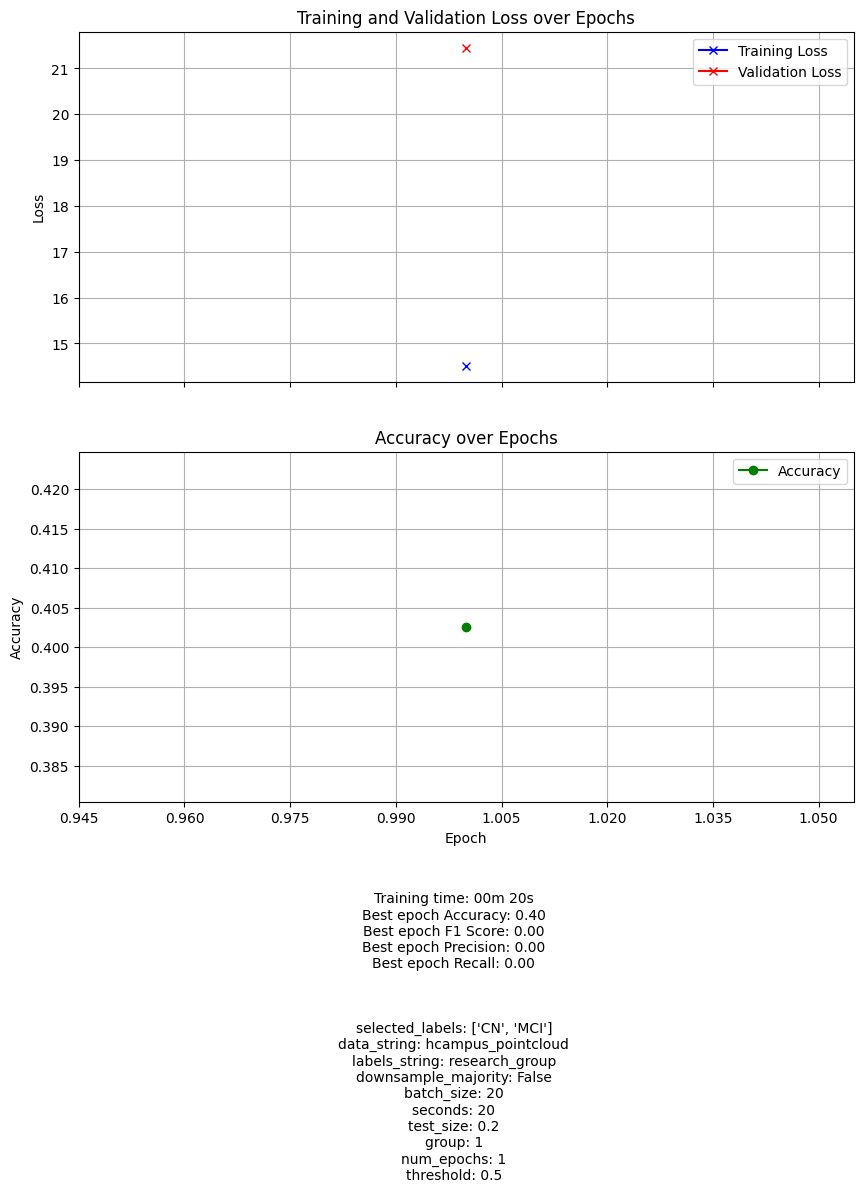

In [12]:
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import datetime

# Plot training loss, validation loss, and accuracy on separate subplots, along with displaying hyperparameters
def plot(training_losses, 
         validation_losses, 
         num_epochs, 
         train_time_str, 
         accuracies, 
         f1s, 
         precisions, 
         recalls, 
         param_list,
         name=None):
    
    best_epoch = accuracies.index(max(accuracies))
    best_accuracy = accuracies[best_epoch]
    best_f1 = f1s[best_epoch]
    best_precision = precisions[best_epoch]
    best_recall = recalls[best_epoch]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
    
    ax1.plot(range(1, num_epochs + 1), training_losses, label='Training Loss', color='blue', marker='x')
    ax1.plot(range(1, num_epochs + 1), validation_losses, label='Validation Loss', color='red', marker='x')
    ax1.set_title('Training and Validation Loss over Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

    ax2.plot(range(1, num_epochs + 1), accuracies, label='Accuracy', color='green', marker='o')
    ax2.set_title('Accuracy over Epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

    info = []
    info.append(train_time_str)
    info.append(f"Best epoch Accuracy: {best_accuracy:.2f}")
    info.append(f"Best epoch F1 Score: {best_f1:.2f}")
    info.append(f"Best epoch Precision: {best_precision:.2f}")
    info.append(f"Best epoch Recall: {best_recall:.2f}")
    info.append("\n\n")

    for param in param_list:
        for name, value in globals().items():
            if value is param:
                info.append(f"{name}: {value}")
    
    info_text = "\n".join(info)
    
    fig.text(0.5, 0.02, info_text, ha='center', va='top', wrap=True, fontsize=10)

    current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S") 
    name = f"plot_{current_time}"
    plt.savefig(f'/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/figs/{name}.png', bbox_inches='tight')

    plt.show()

plot(training_losses, 
     validation_losses, 
     num_epochs, 
     train_time_str, 
     accuracies, 
     f1s, 
     precisions, 
     recalls, 
     [selected_labels, data_string, labels_string, downsample_majority, batch_size, test_size, num_epochs, threshold],
     name=None
)


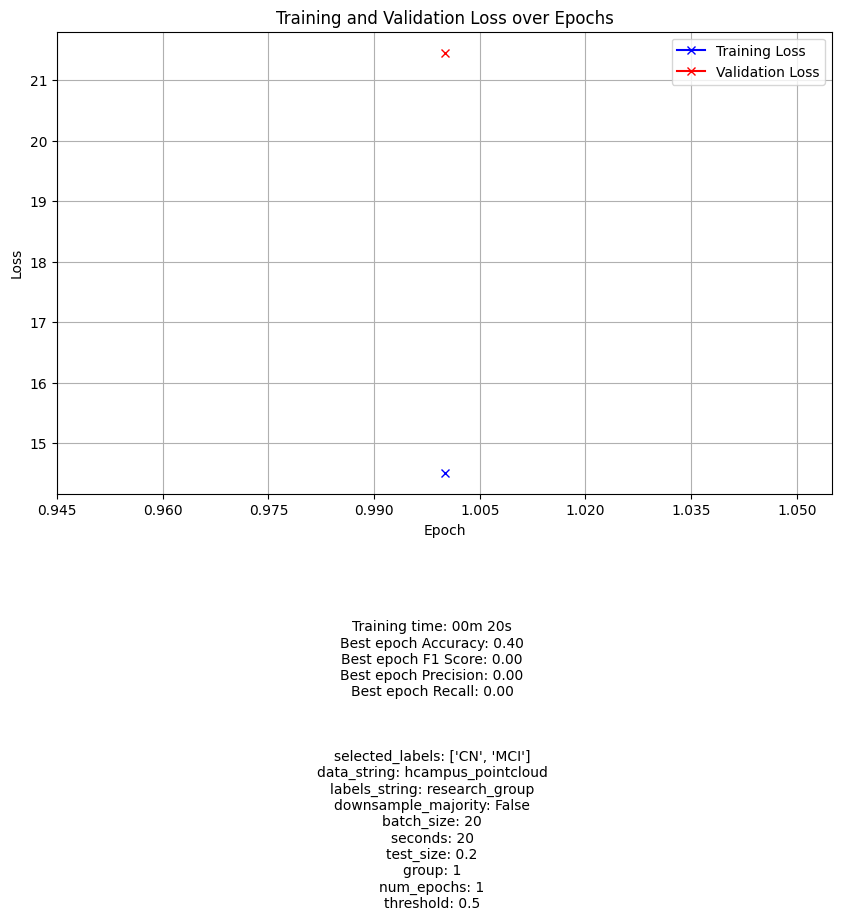

In [13]:

from matplotlib.ticker import MaxNLocator

# Plot training loss and validation loss, along with displaying hyperparameters
def plot(training_losses, 
    validation_losses, 
    num_epochs, 
    train_time_str, 
    accuracies, 
    f1s, 
    precisions, 
    recalls, 
    param_list,
    name=None):
    
    best_accuracy = accuracies[best_epoch]
    best_f1 = f1s[best_epoch]
    best_precision = precisions[best_epoch]
    best_recall = recalls[best_epoch]

    plt.figure(figsize=(10, 6))

    plt.plot(range(1, num_epochs + 1), training_losses, label='Training Loss', color='blue', marker='x')

    plt.plot(range(1, num_epochs + 1), validation_losses, label='Validation Loss', color='red', marker='x')

    plt.title('Training and Validation Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.grid(True)
    
    info = []
    
    info.append(train_time_str)
    info.append(f"Best epoch Accuracy: {best_accuracy:.2f}")
    info.append(f"Best epoch F1 Score: {best_f1:.2f}")
    info.append(f"Best epoch Precision: {best_precision:.2f}")
    info.append(f"Best epoch Recall: {best_recall:.2f}")
    info.append("\n\n")
                
                
    # Get variable names and values to display in plot
    for param in param_list:
        for name, value in globals().items():
            if value is param:
                info.append(f"{name}: {value}")
    

    info_text = "\n".join(info)


    plt.figtext(0.5, -0.1, info_text, ha='center', va='top', wrap=True, fontsize=10)
        
    current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")  # Get current time as a string
    
    name = f"plot_{current_time}"
    
    plt.savefig(f'/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/figs/{name}.png', bbox_inches='tight')

    plt.show()
            

plot(training_losses, 
    validation_losses, 
    num_epochs, 
    train_time_str, 
    accuracies, 
    f1s, 
    precisions, 
    recalls, 
    [selected_labels, data_string, labels_string, downsample_majority, batch_size, test_size, num_epochs, threshold],
    name=None
)

